## `Install some dependencies`

In [1]:
# Upgrade pip, install spacy, and download model
!pip install -q pydot graphviz tqdm spacy termcolor
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 70.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## `Import Important Libraries`

In [195]:
import numpy as np
import pandas as pd
from collections import Counter
import random
from termcolor import colored
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.manifold import TSNE
import spacy

# sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier


# tensorflow
import tensorflow as tf

# gensim & nltk

from gensim.models import Word2Vec, FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

## `Load the Dataset`

In [8]:
df = pd.read_csv('twitter-sanders-apple2.csv', encoding='ISO=8859-1')
df.head()

,class,text
0,Pos,Now all @Apple has to do is get swype on the i...
1,Pos,@Apple will be adding more carrier support to ...
2,Pos,Hilarious @youtube video - guy does a duet wit...
3,Pos,@RIM you made it too easy for me to switch to ...
4,Pos,I just realized that the reason I got into twi...


## `Exploratory Data Analysis`

In [9]:
print('The Shape of the Dataset is: ', df.shape)

The Shape of the Dataset is:  (479, 2)


In [10]:
## Check the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   479 non-null    object
 1   text    479 non-null    object
dtypes: object(2)
memory usage: 7.6+ KB


In [7]:
## DataTypes
df.dtypes

,0
class,object
text,object


In [12]:
## Check null values
df.isnull().sum(axis=0)

,0
class,0
text,0


In [13]:
## Check the Traget values
df['class'].unique()

array(['Pos', 'Neg'], dtype=object)

In [16]:
## Distr. of target
df['class'].value_counts()

,count
class,
Neg,316
Pos,163


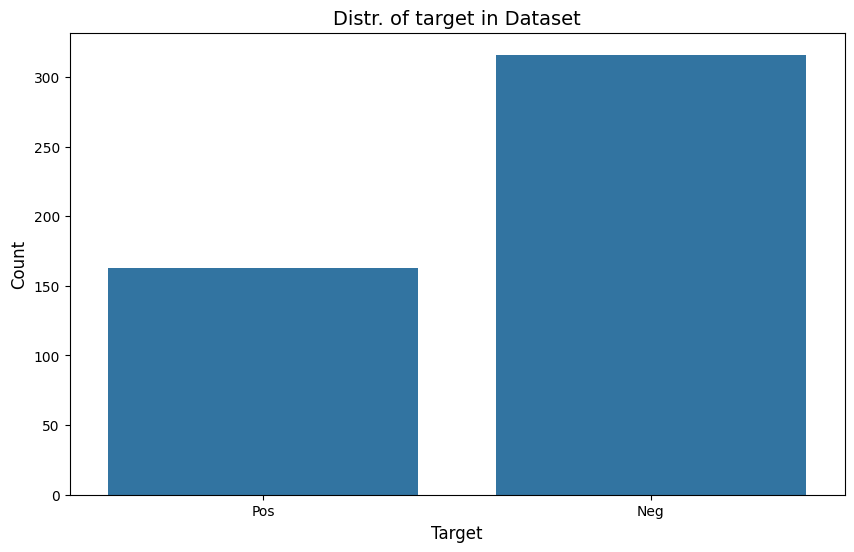

In [19]:
## countplot of target
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='class')
plt.title('Distr. of target in Dataset', fontsize=14, c='k')
plt.xlabel('Target', c='k', fontsize=12)
plt.ylabel('Count', c='k', fontsize=12)
plt.show()

In [20]:
## Assign values to be: 0 is Negstive, 1 is Positive
for i in range(len(df['class'])):
  if df['class'][i] == 'Pos':
    df['class'][i] = 1
  else:
    df['class'][i] = 0


print(df['class'].unique())

[1 0]


## `Text Cleaning & Visualization`

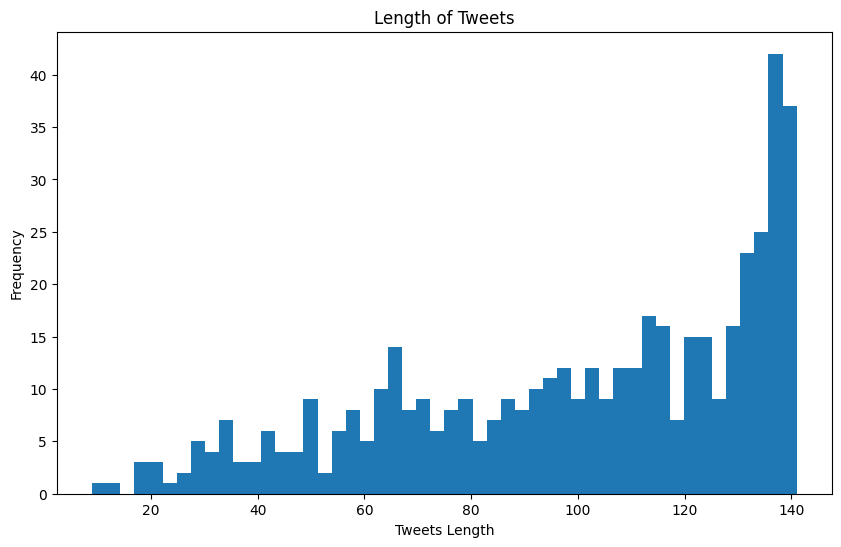

In [21]:
## Check Length of Tweets
length_tweets = df['text'].str.len()
## Plotting
plt.figure(figsize=(10, 6))
plt.hist(length_tweets, bins=50)
plt.title('Length of Tweets')
plt.xlabel('Tweets Length')
plt.ylabel('Frequency')
plt.show()

In [22]:
## Hashtags
def hashtag_extract(x):
    hashtags = []
    ## Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

## Extracting hashtags from non racist tweets
hash_neg = hashtag_extract(df['text'][df['class'] == 0])  ## Negative
hash_pos = hashtag_extract(df['text'][df['class'] == 1])  ## Positive


## Unnesting list
hash_neg = sum(hash_neg, [])
hash_pos = sum(hash_pos, [])

print(hash_pos)

['iPad', 'BlackBerry', 'BlackBerry', 'smallvictory', 'thievingbastards', 'GeniusBar', 'yourdaysarenumbered', 'iPhone4S', 'notjustaboutthephone', 'ios5', 'iPhone4S', 'iPhone4S', 'iPad', 'iPad', 'iphone', 'RVA', 'iphone4s', 'HP', 'iPhone', 'lol', 'backchannel', 'ios5', 'Siri', 'need4s', 'sweet', 'apple', 'probono', 'IPhones', 'smartphone', 'sm', 'technology', 'mack', 'iCloud', 'iOS5', 'geek', 'iphone', 'iphone4S', 'smartphone', 'stevejobs', 'iphone4s', 'fb', 'iOS5', 'readinglists', 'nowicanspendevenmoretimeonmyphone', '10twitterpeopleiwouldliketomeet', 'MacOSC', 'iphone', 'iPhone4S', 'android', 'CardsApp', 'appletv', 'PrincessOfChina', 'wow', 'ios5', 'ios5', 'ios5', 'lovemyiphone', 'iPhone', 'iPhone', 'MakeMeProud', '365daysofgratefulness', 'hypo', 'D', 'tri', 'hypo', 'D', 'tri', 'iPhone4S', 'ios5', 'genius', 'magic', 'Siri', 'imamac', 'iOS5', 'awesome', 'addicted', 'iOS5', 'Blackberry', 'iPhone', 'creative', 'siri', 'ipod4s', 'iOS5', 'newfeature', 'iOS5', 'iOS5', 'iphone4s', 'iOs5', 'Be

In [23]:
## Hashtags in Tweets
a_neg = nltk.FreqDist(hash_neg)
a_pos = nltk.FreqDist(hash_pos)

print(a_pos)

<FreqDist with 61 samples and 91 outcomes>


Text(0.5, 80.7222222222222, '')

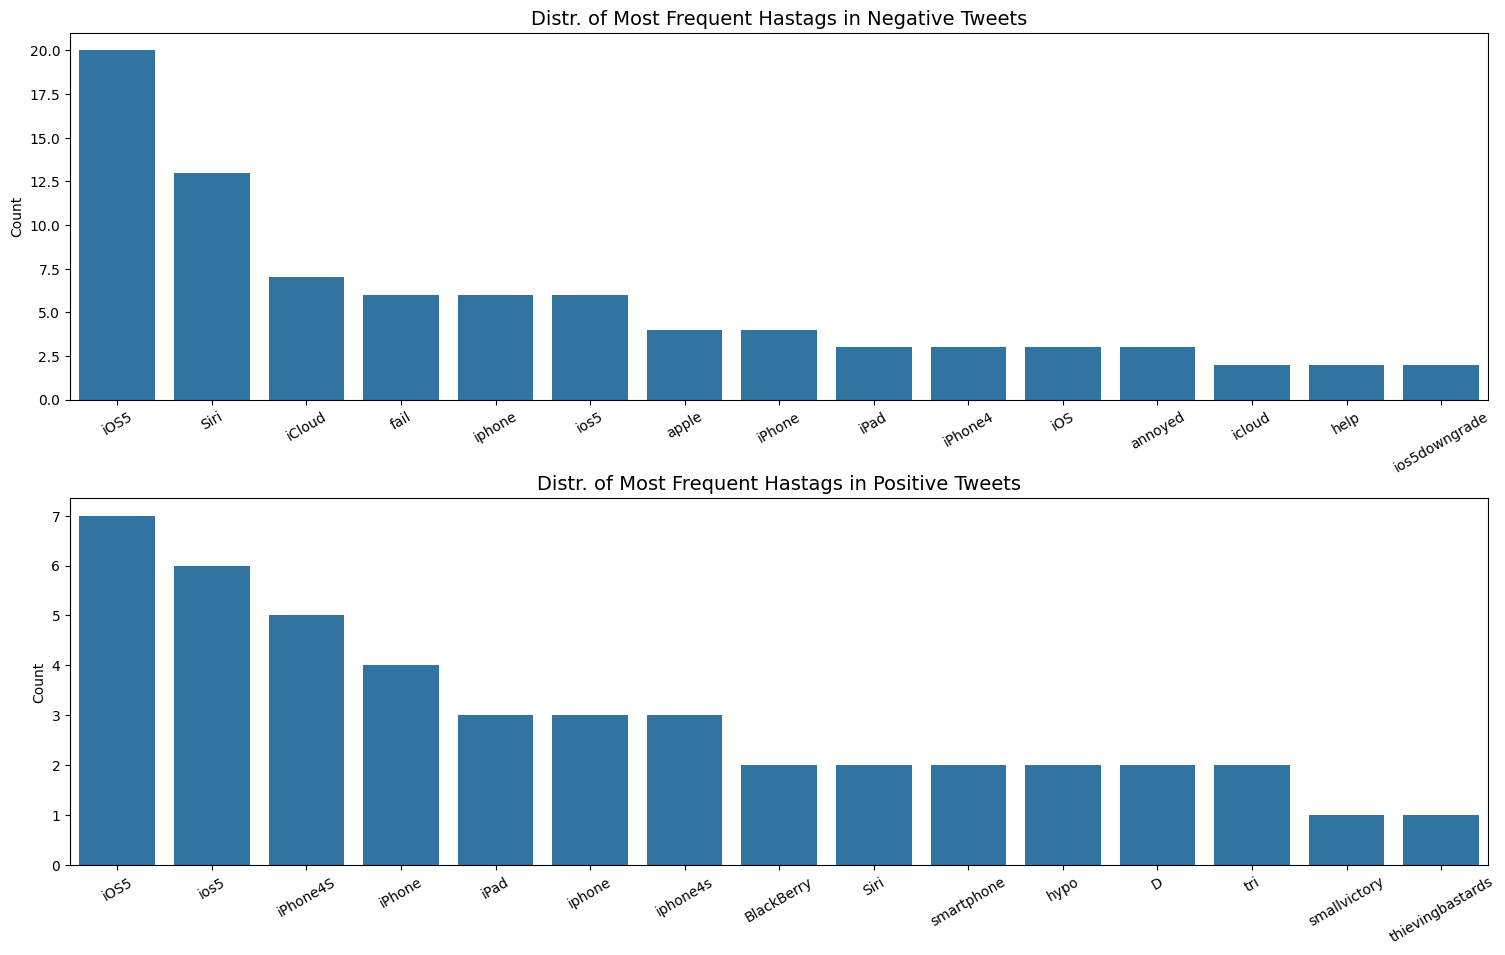

In [24]:

## Negative Tweets
df_neg = pd.DataFrame({'Hashtag': list(a_neg.keys()),
                  'Count': list(a_neg.values())})

## Positive Tweets
df_pos = pd.DataFrame({'Hashtag': list(a_pos.keys()),
                  'Count': list(a_pos.values())})

# selecting top 15 most frequent hashtags
df_neg = df_neg.nlargest(columns='Count', n=15)
df_pos = df_pos.nlargest(columns='Count', n=15)

## Plotting
fig, ax = plt.subplots(2, 1, figsize=(16, 10))
fig.tight_layout(pad=5)
plt.sca(ax[0])
sns.barplot(data=df_neg, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Negative Tweets', fontsize=14, c='k')
plt.xlabel('')
##
plt.sca(ax[1])
sns.barplot(data=df_pos, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Positive Tweets', fontsize=14, c='k')
plt.xlabel('')

In [25]:
## Remove unwanted text patterns from the tweets
def remove_pattern(input_txt: str, pattern: str):
    ''' This Function takes the input and pattern you want to remove

    Args:
    *****
        (input_text: str) --> The text you want to apply the function to it.
        (pattern: str) --> The pattern you want to remove from the text.
    '''

    input_txt = re.sub(pattern, '', input_txt)
    return input_txt

In [26]:
## Removing @user in tweets, and apply the function
df['text'] = df['text'].apply(remove_pattern, pattern=r'@[\w]*')
df.head()

,class,text
0,1,Now all has to do is get swype on the iphone ...
1,1,will be adding more carrier support to the iP...
2,1,Hilarious video - guy does a duet with 's Si...
3,1,you made it too easy for me to switch to iPh...
4,1,I just realized that the reason I got into twi...


In [27]:
## An exmaple before removing links
df['text'].iloc[400]

"Dear  how convenient/handy/thoughtful/smart that after iPhone #ios5 update you're apps won't work anymore! (none!!!) :( #gr%\\mbl^.%)"

In [28]:
## Define a regular expression pattern to match URLs
## Apply the above function
df['text'] = df['text'].apply(remove_pattern, pattern=r'https?://\S+|www\.\S+')
df.head()

,class,text
0,1,Now all has to do is get swype on the iphone ...
1,1,will be adding more carrier support to the iP...
2,1,Hilarious video - guy does a duet with 's Si...
3,1,you made it too easy for me to switch to iPh...
4,1,I just realized that the reason I got into twi...


In [29]:
## An exmaple before removing repeated chars
df['text'].iloc[0]

'Now all  has to do is get swype on the iphone and it will be crack. Iphone that is'

In [30]:
## A Function to remove excessive repeated chars while preserving correct words
def remove_excessive_repeated_characters(input_string, max_repeats=2):
    ## Define a regular expression pattern to match consecutive repeated characters
    pattern = f"(\\w)\\1{{{max_repeats},}}"
    ## Replace the matched pattern with a single occurrence of the character
    cleaned_string = re.sub(pattern, r"\1", input_string)

    return cleaned_string

## Apply the above function
df['text'] = df['text'].apply(remove_excessive_repeated_characters)
df.head()

,class,text
0,1,Now all has to do is get swype on the iphone ...
1,1,will be adding more carrier support to the iP...
2,1,Hilarious video - guy does a duet with 's Si...
3,1,you made it too easy for me to switch to iPh...
4,1,I just realized that the reason I got into twi...


In [31]:
## The same exmaple after removing repeated chars
df['text'].iloc[0]

'Now all  has to do is get swype on the iphone and it will be crack. Iphone that is'

In [32]:
## Check on sample before mapping emoticons
df['text'].iloc[73]

'Apple sells 4 million iPhones in 3 days  keep doing what you are doing because you are doing it well! '

In [33]:
## Convert Emojis to Text : example 😀 to Happy , 😢 Sad
## This Dataset doesn't contains emojis, but it contains emotioncons like that :D, :)
## So, We can't demojize, but we will map the moticons to its meaning.

emoticon_meanings = {
    ":)": "Happy",
    ":(": "Sad",
    ":D": "Very Happy",
    ":|": "Neutral",
    ":O": "Surprised",
    "<3": "Love",
    ";)": "Wink",
    ":P": "Playful",
    ":/": "Confused",
    ":*": "Kiss",
    ":')": "Touched",
    "XD": "Laughing",
    ":3": "Cute",
    ">:(": "Angry",
    ":-O": "Shocked",
    ":|]": "Robot",
    ":>": "Sly",
    "^_^": "Happy",
    "O_o": "Confused",
    ":-|": "Straight Face",
    ":X": "Silent",
    "B-)": "Cool",
    "<(‘.'<)": "Dance",
    "(-_-)": "Bored",
    "(>_<)": "Upset",
    "(¬‿¬)": "Sarcastic",
    "(o_o)": "Surprised",
    "(o.O)": "Shocked",
    ":0": "Shocked",
    ":*(": "Crying",
    ":v": "Pac-Man",
    "(^_^)v": "Double Victory",
    ":-D": "Big Grin",
    ":-*": "Blowing a Kiss",
    ":^)": "Nosey",
    ":-((": "Very Sad",
    ":-(": "Frowning",
}


## Function to replace emoticons with their meanings
def convert_emoticons(text: str):
    ''' This Function is to replace the emoticons with thier meaning instead
    '''
    for emoticon, meaning in emoticon_meanings.items():
        text = text.replace(emoticon, meaning)
    return text

## Apply the function on our dataset
df['text'] = df['text'].apply(convert_emoticons)
df.head()

,class,text
0,1,Now all has to do is get swype on the iphone ...
1,1,will be adding more carrier support to the iP...
2,1,Hilarious video - guy does a duet with 's Si...
3,1,you made it too easy for me to switch to iPh...
4,1,I just realized that the reason I got into twi...


In [34]:
## The same exmaple after mapping emoticons
df['text'].iloc[73]

'Apple sells 4 million iPhones in 3 days  keep doing what you are doing because you are doing it well! '

In [35]:
## Removing Punctuations, Numbers, and Special Characters
df['text'] = df['text'].str.replace('[^a-zA-Z#]', ' ')
df.head()

,class,text
0,1,Now all has to do is get swype on the iphone ...
1,1,will be adding more carrier support to the iP...
2,1,Hilarious video - guy does a duet with 's Si...
3,1,you made it too easy for me to switch to iPh...
4,1,I just realized that the reason I got into twi...


In [38]:
## Removing Short Words
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df.head()

,class,text
0,1,swype iphone will crack. Iphone that
1,1,will adding more carrier support iPhone (just ...
2,1,Hilarious video does duet with Siri. Pretty mu...
3,1,made easy switch iPhone.
4,1,just realized that reason into twitter ios5 th...


In [39]:
# check on sample before mapping
df['text'].iloc[123]

'&lt;3'

In [40]:
## Call the above function (remove_pattern), We want to remove the numbers from words
## We don't remove all numbers on the dataset, The pattern only removes the numbers within the words
df['text'] = np.vectorize(remove_pattern)(input_txt=df['text'], pattern='(?<=\w)\d+|\d+(?=\w)')
df.head()

,class,text
0,1,swype iphone will crack. Iphone that
1,1,will adding more carrier support iPhone (just ...
2,1,Hilarious video does duet with Siri. Pretty mu...
3,1,made easy switch iPhone.
4,1,just realized that reason into twitter ios thanks


In [41]:
## Define a regular expression pattern to match special characters
## Apply the function to the dataset
df['text'] = df['text'].apply(remove_pattern, pattern=r'[!@#$%^&*()_+{}\[\]:;<>,.?~\\|\/-]')
df.head()

,class,text
0,1,swype iphone will crack Iphone that
1,1,will adding more carrier support iPhone just a...
2,1,Hilarious video does duet with Siri Pretty muc...
3,1,made easy switch iPhone
4,1,just realized that reason into twitter ios thanks


In [42]:
## The same exmaple after removing special chars
df['text'].iloc[2]

'Hilarious video does duet with Siri Pretty much sums love affair'

In [43]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [45]:
## A Function to remove redundant words like (I've, You'll)
## Again, It is challenging

def remove_redundant_words_extra_spaces(text: str):
    ## Remove contractions using regular expressions
    contraction_pattern = re.compile(r"'\w+|\w+'\w+|\w+'")
    text = contraction_pattern.sub('', text)

    ## Define a set of stopwords
    stop_words = set(stopwords.words("english"))

    ## Remove stopwords and extra spaces
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    clean_text = ' '.join(filtered_words)

    ## Remove extra spaces
    clean_text = ' '.join(clean_text.split())

    return clean_text


## Apply the above function
df['text'] = df['text'].apply(remove_redundant_words_extra_spaces)

In [47]:
## Call the above function (remove_pattern), We want to remove the numbers from words
## We don't remove all numbers on the dataset, The pattern only removes the numbers within the words
df['text'] = np.vectorize(remove_pattern)(input_txt=df['text'], pattern='(?<=\w)\d+|\d+(?=\w)')
df.head()


,class,text
0,1,swype iphone crack Iphone
1,1,adding carrier support iPhone announced
2,1,Hilarious video duet Siri Pretty much sums lov...
3,1,made easy switch iPhone
4,1,realized reason twitter ios thanks


In [51]:
# An example of short words
df['text'].iloc[123]

''

In [52]:
## Removing Short Words
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df.head()

,class,text
0,1,swype iphone crack Iphone
1,1,adding carrier support iPhone announced
2,1,Hilarious video duet Siri Pretty much sums lov...
3,1,made easy switch iPhone
4,1,realized reason twitter thanks


In [53]:
# After removing short words
df['text'].iloc[123]

''

In [55]:
# Removing rows with no text
df = df[df['text'] != '']

In [58]:
# After removing the whole row
df['text'].iloc[123]

'nice store replaced phone gratis showed hairline crack screen thanks'

In [57]:
## Download the dataset here at this step before Stemming or Lemmatizing
df.to_excel('twitter-sanders-apple2.xlsx', index=False)
df.to_csv('twitter-sanders-apple2-cleaned.csv', index=False)

## `Split the Dataset`

In [59]:
# Split to X & y
X = df['text']
y = df['class']

# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## `Tokenization`

In [62]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [63]:
# Function to preprocess and tokenize text
def preprocess_text(text: str):
    # Lowercase and tokenize
    tokens = word_tokenize(text.lower())
    # Remove punctuation and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

# Preprocess and tokenize the training data
X_train_tokenized = [preprocess_text(doc) for doc in tqdm(X_train, desc='Tokenizing')]

Tokenizing:   0%|          | 0/380 [00:00<?, ?it/s]

## `Word2Vec Model (CBOW & Skip-gram)`

In [64]:
# Embedding size
EMBED_SIZE = 100

In [65]:
# Word2Vec Model
model_w2v = Word2Vec(sentences=X_train_tokenized,
                     vector_size=EMBED_SIZE,
                     window=5,
                     min_count=2,
                     sg=1,
                     hs=0,
                     negative=10,
                     workers=2,
                     seed=45,
                     epochs=10)

In [66]:
# Vocab size
len(model_w2v.wv)

436

In [67]:
# Transform the text data to Word2Vec embeddings
def text_to_w2v(text, model):

    # Call the preprocessing function
    tokens = preprocess_text(text)

    # Get the embeddings
    embeddings = [model.wv[word] for word in tokens if word in model.wv]

    if embeddings:
        # Average the embeddings
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Apply
X_train_w2v = [text_to_w2v(doc, model_w2v) for doc in tqdm(X_train, desc='Embedding Training Data')]
X_test_w2v = [text_to_w2v(doc, model_w2v) for doc in tqdm(X_test, desc='Embedding Testing Data')]

Embedding Training Data:   0%|          | 0/380 [00:00<?, ?it/s]

Embedding Testing Data:   0%|          | 0/95 [00:00<?, ?it/s]

In [68]:
# Word2Vec representation
model_w2v.wv['apple']

array([-0.27677518, -0.13386399, -0.05307525, -0.08548515,  0.278483  ,
        0.32970294, -0.19740878, -0.0321655 ,  0.18755063, -0.27661964,
       -0.15130061, -0.06554846,  0.04083232,  0.02193907, -0.19351627,
       -0.15971611, -0.13880879,  0.0514928 ,  0.00745731, -0.0050028 ,
        0.04703087,  0.02776443,  0.02561056, -0.10560703, -0.17057343,
        0.1364025 , -0.31418228,  0.26416606,  0.04764632, -0.11381017,
        0.4192879 , -0.14576   , -0.13008647,  0.1290012 , -0.08728905,
        0.31714144, -0.1058065 ,  0.21835892, -0.4134444 ,  0.02302409,
       -0.00618158,  0.08372533,  0.24907598, -0.0242166 ,  0.04283819,
       -0.30644688,  0.29428965,  0.06444905,  0.14344552, -0.21541938,
       -0.05547208,  0.13629705,  0.1224508 ,  0.18608062, -0.07870689,
       -0.21389295,  0.3198328 , -0.08861139, -0.04681642, -0.1809402 ,
        0.20569278,  0.00180115, -0.10158674, -0.12292992, -0.14065808,
       -0.03631955,  0.15838066,  0.01473784,  0.00919426,  0.06

In [69]:
# Key to index
model_w2v.wv.key_to_index

{'iphone': 0,
 'siri': 1,
 'store': 2,
 'phone': 3,
 'thanks': 4,
 'ipad': 5,
 'update': 6,
 'apple': 7,
 'iphones': 8,
 'time': 9,
 'service': 10,
 'icloud': 11,
 'love': 12,
 'apps': 13,
 'great': 14,
 'itunes': 15,
 'upgrade': 16,
 'customer': 17,
 'really': 18,
 'better': 19,
 'shit': 20,
 'dear': 21,
 'made': 22,
 'work': 23,
 'right': 24,
 'like': 25,
 'battery': 26,
 'much': 27,
 'thank': 28,
 'would': 29,
 'done': 30,
 'still': 31,
 'issues': 32,
 'network': 33,
 'well': 34,
 'restore': 35,
 'think': 36,
 'loving': 37,
 'fucking': 38,
 'fail': 39,
 'fuck': 40,
 'good': 41,
 'going': 42,
 'another': 43,
 'today': 44,
 'need': 45,
 'screen': 46,
 'happy': 47,
 'since': 48,
 'life': 49,
 'ever': 50,
 'support': 51,
 'using': 52,
 'never': 53,
 'actually': 54,
 'wait': 55,
 'little': 56,
 'macbook': 57,
 'lion': 58,
 'every': 59,
 'hours': 60,
 'send': 61,
 'back': 62,
 'awesome': 63,
 'nothing': 64,
 'data': 65,
 'must': 66,
 'making': 67,
 'feature': 68,
 'make': 69,
 'amazing': 

In [70]:
# Find similar words to the given word
sim_words_w2v = model_w2v.wv.most_similar('apple', topn=10)
sim_words_w2v

[('would', 0.9989256858825684),
 ('hour', 0.9989035725593567),
 ('charge', 0.9988939166069031),
 ('update', 0.9988845586776733),
 ('iphone', 0.9988813400268555),
 ('better', 0.9988721609115601),
 ('icloud', 0.9988531470298767),
 ('actually', 0.9988475441932678),
 ('really', 0.9988436102867126),
 ('first', 0.9988398551940918)]

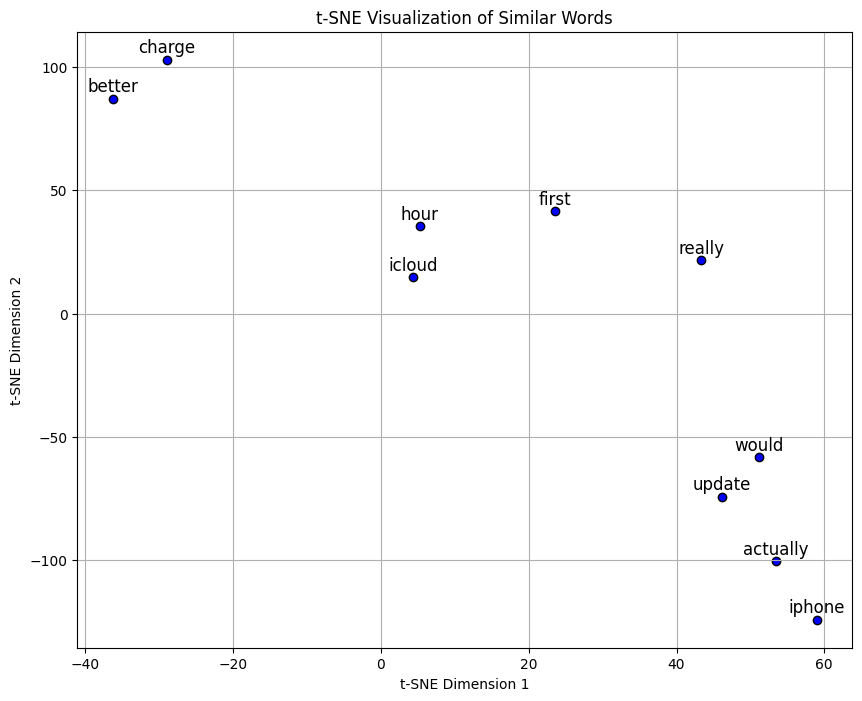

In [71]:
# Visualizing the most similar words using t-sne and scatter plot
# Get vectors and words
words = [word for word, _ in sim_words_w2v]
word_vectors = [model_w2v.wv[word] for word in words]
word_vectors = np.array(word_vectors)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, perplexity=2, init='pca', random_state=0)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], marker='o', c='b', edgecolors='k')

# Annotate the points with the word labels
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=12,
                 textcoords='offset points', xytext=(0, 5), ha='center', fontproperties='Arial', family='Arial')

# Plot the figure
plt.title(f"t-SNE Visualization of Similar Words")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

In [73]:
# Odd-One-Out
lst_example = ['battery', 'apple', 'iphone']
model_w2v.wv.doesnt_match(lst_example)

'apple'

In [74]:
# Analogy
model_w2v.wv.most_similar(positive=['apple', 'iphone'], negative=['battery'])

[('actually', 0.9979386329650879),
 ('architecture', 0.9979254007339478),
 ('dont', 0.9978933334350586),
 ('software', 0.9978781342506409),
 ('magical', 0.9978709816932678),
 ('update', 0.9978625774383545),
 ('would', 0.997846245765686),
 ('thanks', 0.9978461265563965),
 ('sprint', 0.9978333711624146),
 ('else', 0.9978296160697937)]

## `Train a Classifier`

In [105]:
# GradientBoosting Classifier (GBC)
clf = GradientBoostingClassifier()
y_train = y_train.astype('int')
y_test = y_test.astype('int')
clf.fit(X_train_w2v, y_train)

y_pred_test = clf.predict(X_test_w2v)

In [106]:
# Report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84        63
           1       0.72      0.56      0.63        32

    accuracy                           0.78        95
   macro avg       0.76      0.73      0.74        95
weighted avg       0.77      0.78      0.77        95



In [107]:
accuracy_score(y_test, y_pred_test)

0.7789473684210526

## `Using Cosine Similarity Get Top Similar`

In [116]:
y_test = np.array(y_test)
y_train = np.array(y_train)

for i in random.choices(range(0, len(X_test)), k=5):
    print(f"ID: {i}")
    print("True label:", colored(y_test[i], 'green'))
    distances = cosine_similarity(X_test_w2v[i].reshape(1, EMBED_SIZE), X_train_w2v).flatten()
    indices = np.argsort(distances)[::-1]
    for _, j in enumerate(indices[:3]):
        print(f"{_} nearest label is {colored(y_train[j], 'green' if y_train[j]==y_test[i] else 'red')}",
             f"similarity: {colored(round(distances[j], 3), 'yellow')}")

ID: 53
True label: 0
0 nearest label is 0 similarity: 1.0
1 nearest label is 0 similarity: 1.0
2 nearest label is 0 similarity: 1.0
ID: 87
True label: 0
0 nearest label is 1 similarity: 1.0
1 nearest label is 0 similarity: 1.0
2 nearest label is 0 similarity: 1.0
ID: 49
True label: 0
0 nearest label is 0 similarity: 1.0
1 nearest label is 0 similarity: 1.0
2 nearest label is 0 similarity: 1.0
ID: 8
True label: 1
0 nearest label is 0 similarity: 0.999
1 nearest label is 0 similarity: 0.999
2 nearest label is 1 similarity: 0.999
ID: 78
True label: 0
0 nearest label is 0 similarity: 1.0
1 nearest label is 0 similarity: 1.0
2 nearest label is 0 similarity: 1.0


In [117]:
# List to append in it the predicted of test labels
y_pred_test = []

# Loop over the entire test dataset
for i in range(len(X_test)):
    # Compute cosine similarity between the test instance and all training instances
    distances = cosine_similarity(X_test_w2v[i].reshape(1, EMBED_SIZE), X_train_w2v).flatten()
    # Get the indices of the training instances sorted by similarity in descending order
    indices = np.argsort(distances)[::-1]
    # Get the labels of the three nearest neighbors
    nearest_labels = [y_train[j] for j in indices[:3]]
    # Determine the most common label among the three nearest neighbors
    y_pred_each = Counter(nearest_labels).most_common(1)[0][0]
    # Append to list
    y_pred_test.append(y_pred_each)

# Get Accuracy score
acc = accuracy_score(y_test, y_pred_test)
print(f'Acccuray Score using cosine simlarity is: {acc*100:.3f} %') # using cosine similarity as a metric

Acccuray Score using cosine simlarity is: 73.684 %


## `Using Euclidean Distance for measuring similarity`

In [118]:
for i in random.choices(range(0, len(X_test)), k=5):
    print(f"ID: {i}")
    print("True label:", colored(y_test[i], 'green'))
    distances = euclidean_distances(X_test_w2v[i].reshape(1, EMBED_SIZE), X_train_w2v).flatten()
    indices = np.argsort(distances)
    for _, j in enumerate(indices[:3]):
        print(f"{_} nearest label is {colored(y_train[j], 'green' if y_train[j]==y_test[i] else 'red')}",
             f"similarity: {colored(round(distances[j], 3), 'yellow')}")

ID: 21
True label: 0
0 nearest label is 1 similarity: 0.031
1 nearest label is 0 similarity: 0.032
2 nearest label is 0 similarity: 0.034
ID: 19
True label: 1
0 nearest label is 0 similarity: 0.056
1 nearest label is 0 similarity: 0.057
2 nearest label is 0 similarity: 0.058
ID: 75
True label: 0
0 nearest label is 0 similarity: 0.034
1 nearest label is 0 similarity: 0.035
2 nearest label is 0 similarity: 0.036
ID: 34
True label: 0
0 nearest label is 0 similarity: 0.028
1 nearest label is 0 similarity: 0.029
2 nearest label is 0 similarity: 0.03
ID: 71
True label: 0
0 nearest label is 0 similarity: 0.032
1 nearest label is 0 similarity: 0.034
2 nearest label is 0 similarity: 0.034


In [119]:
# List to append in it the predicted of test labels
y_pred_test = []

# Loop over the entire test dataset
for i in range(len(X_test)):

    # Compute euclidean_distances between the test instance and all training instances
    distances = euclidean_distances(X_test_w2v[i].reshape(1, EMBED_SIZE), X_train_w2v).flatten()
    # Get the indices of the training instances sorted by distance in ascending order
    indices = np.argsort(distances)
    # Get the labels of the three nearest neighbors
    nearest_labels = [y_train[j] for j in indices[:3]]
    # Determine the most common label among the three nearest neighbors
    y_pred_each = Counter(nearest_labels).most_common(1)[0][0]
    # Append to list
    y_pred_test.append(y_pred_each)

# Get Accuracy score
acc = accuracy_score(y_test, y_pred_test)
print(f'Acccuray Score using Euclidean Distance is: {acc*100:.3f} %') # usign euclidean distance

Acccuray Score using Euclidean Distance is: 64.211 %




---



## `FastText Model`

In [120]:
# Initialize the FastText model
model_fasttext = FastText(sentences=X_train_tokenized,
                        vector_size=EMBED_SIZE,
                        window=5,
                        min_count=2,
                        sg=1,
                        hs=0,
                        negative=10,
                        workers=2,
                        seed=34,
                        epochs=10,
                        min_n=3, max_n=6)

In [121]:
# Vocab size
len(model_fasttext.wv)

436

In [122]:
# Transform the text data to FastText embeddings
def text_to_fasttext(text, model):

    # Call the preprocessing function
    tokens = preprocess_text(text)

    # Get the emeddings
    embeddings = [model.wv[word] for word in tokens if word in model.wv]

    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)


# Apply
X_train_fasttext = [text_to_fasttext(doc, model_fasttext) for doc in tqdm(X_train, desc='Embedding Training Data')]
X_test_fasttext = [text_to_fasttext(doc, model_fasttext) for doc in tqdm(X_test, desc='Embedding Testing Data')]

Embedding Training Data:   0%|          | 0/380 [00:00<?, ?it/s]

Embedding Testing Data:   0%|          | 0/95 [00:00<?, ?it/s]

In [124]:
# FastText representation
model_fasttext.wv['apple']

array([ 0.00170868,  0.18656082,  0.09313121,  0.30036196, -0.13037546,
        0.4007979 ,  0.1352676 , -0.16716671,  0.05724604, -0.16459508,
       -0.01490682, -0.02714113, -0.08034994, -0.24734725, -0.30856475,
        0.04236465,  0.23992701, -0.2258763 ,  0.1821722 , -0.13006946,
        0.331781  , -0.12730631, -0.2403414 ,  0.03533458, -0.31303352,
        0.08694313, -0.07773615,  0.12081531,  0.34967116, -0.17182875,
        0.03876102,  0.0559285 , -0.0903272 ,  0.10730473,  0.06564678,
        0.21650128,  0.02482043,  0.00265647,  0.37776724,  0.05743438,
       -0.30547315,  0.22716698,  0.2317628 , -0.1924449 , -0.05813802,
        0.10182975, -0.13384356,  0.02797725,  0.08320688,  0.21651705,
        0.01907307, -0.13006212,  0.12735309,  0.19664042,  0.09070306,
        0.02974143,  0.1428064 , -0.4362449 ,  0.04732312,  0.34035593,
        0.06246434, -0.08822253, -0.02099797,  0.24045493,  0.02196685,
        0.38520283,  0.22094038, -0.08529138, -0.1463056 , -0.15

In [125]:
# Key to index
model_fasttext.wv.key_to_index

{'iphone': 0,
 'siri': 1,
 'store': 2,
 'phone': 3,
 'thanks': 4,
 'ipad': 5,
 'update': 6,
 'apple': 7,
 'iphones': 8,
 'time': 9,
 'service': 10,
 'icloud': 11,
 'love': 12,
 'apps': 13,
 'great': 14,
 'itunes': 15,
 'upgrade': 16,
 'customer': 17,
 'really': 18,
 'better': 19,
 'shit': 20,
 'dear': 21,
 'made': 22,
 'work': 23,
 'right': 24,
 'like': 25,
 'battery': 26,
 'much': 27,
 'thank': 28,
 'would': 29,
 'done': 30,
 'still': 31,
 'issues': 32,
 'network': 33,
 'well': 34,
 'restore': 35,
 'think': 36,
 'loving': 37,
 'fucking': 38,
 'fail': 39,
 'fuck': 40,
 'good': 41,
 'going': 42,
 'another': 43,
 'today': 44,
 'need': 45,
 'screen': 46,
 'happy': 47,
 'since': 48,
 'life': 49,
 'ever': 50,
 'support': 51,
 'using': 52,
 'never': 53,
 'actually': 54,
 'wait': 55,
 'little': 56,
 'macbook': 57,
 'lion': 58,
 'every': 59,
 'hours': 60,
 'send': 61,
 'back': 62,
 'awesome': 63,
 'nothing': 64,
 'data': 65,
 'must': 66,
 'making': 67,
 'feature': 68,
 'make': 69,
 'amazing': 

In [126]:
# Find similar words to the given word
sim_words_fasttext = model_fasttext.wv.most_similar('apple', topn=10)
sim_words_fasttext

[('replacing', 0.9999659657478333),
 ('messages', 0.9999619722366333),
 ('disappointed', 0.999961793422699),
 ('connecting', 0.9999615550041199),
 ('appreciated', 0.9999614953994751),
 ('computer', 0.9999614953994751),
 ('people', 0.999961256980896),
 ('service', 0.9999611377716064),
 ('complain', 0.9999604821205139),
 ('recognition', 0.9999604821205139)]

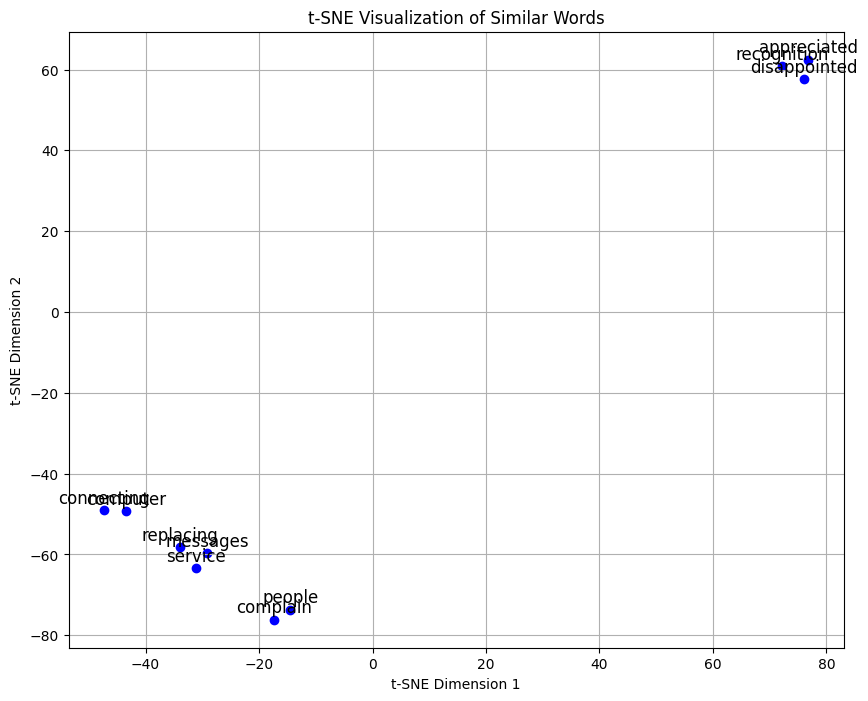

In [127]:
# Visualizing the most similar words using t-sne and sactterplot
# Get vectors and words
words = [word for word, _ in sim_words_fasttext]
word_vectors = [model_fasttext.wv[word] for word in words]
word_vectors = np.array(word_vectors)


# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, perplexity=2, init='pca', random_state=0)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], marker='o', c='b')

# Annotate points with word labels
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=12, textcoords='offset points',
                 xytext=(0,5), ha='center', fontproperties='Arial', family='Arial')


plt.title(f"t-SNE Visualization of Similar Words")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

In [128]:
# Odd-One-Out
lst_exmaple = ['battery', 'apple', 'iphone']
model_fasttext.wv.doesnt_match(lst_exmaple)

'apple'

In [129]:
# Analogy
model_fasttext.wv.most_similar(positive=['apple', 'iphone'], negative=['battery'])

[('phone', 0.9999262690544128),
 ('iphones', 0.9999192357063293),
 ('connection', 0.9999188184738159),
 ('people', 0.9999166131019592),
 ('connecting', 0.9999159574508667),
 ('replacing', 0.9999157786369324),
 ('promised', 0.999913215637207),
 ('replace', 0.9999123811721802),
 ('replaced', 0.9999121427536011),
 ('registered', 0.9999112486839294)]

## `Train a classifier`

In [147]:
# GradientBoosting Classifier
clf = GradientBoostingClassifier()
clf.fit(X_train_fasttext, y_train)

y_pred_test = clf.predict(X_test_fasttext)

In [148]:
# Report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.73      0.90      0.81        63
           1       0.65      0.34      0.45        32

    accuracy                           0.72        95
   macro avg       0.69      0.62      0.63        95
weighted avg       0.70      0.72      0.69        95



In [149]:
accuracy_score(y_test, y_pred_test) # of a classifier

0.7157894736842105

## `2. Using Cosine Similarity Get Top Similar`

In [150]:
for i in random.choices(range(0, len(X_test)), k=5):
    print(f"ID: {i}")
    print("True label:", colored(y_test[i], 'green'))
    distances = cosine_similarity(X_test_fasttext[i].reshape(1, EMBED_SIZE), X_train_fasttext).flatten()
    indices = np.argsort(distances)[::-1]
    for _, j in enumerate(indices[:3]):
        print(f"{_} nearest label is {colored(y_train[j], 'green' if y_train[j]==y_test[i] else 'red')}",
             f"similarity: {colored(round(distances[j], 3), 'yellow')}")

ID: 13
True label: 1
0 nearest label is 1 similarity: 1.0
1 nearest label is 0 similarity: 1.0
2 nearest label is 1 similarity: 1.0
ID: 77
True label: 0
0 nearest label is 0 similarity: 1.0
1 nearest label is 0 similarity: 1.0
2 nearest label is 0 similarity: 1.0
ID: 11
True label: 0
0 nearest label is 1 similarity: 1.0
1 nearest label is 0 similarity: 1.0
2 nearest label is 0 similarity: 1.0
ID: 0
True label: 1
0 nearest label is 0 similarity: 1.0
1 nearest label is 1 similarity: 1.0
2 nearest label is 1 similarity: 1.0
ID: 27
True label: 1
0 nearest label is 0 similarity: 1.0
1 nearest label is 1 similarity: 1.0
2 nearest label is 0 similarity: 1.0


In [151]:
# List to append in it the predicted of test labels
y_pred_test = []

# Loop over the entire test dataset
for i in range(len(X_test)):
    # Compute cosine similarity between the test instance and all training instances
    distances = cosine_similarity(X_test_fasttext[i].reshape(1, EMBED_SIZE), X_train_fasttext).flatten()
    # Get the indices of the training instances sorted by similarity in descending order
    indices = np.argsort(distances)[::-1]
    # Get the labels of the three nearest neighbors
    nearest_labels = [y_train[j] for j in indices[:3]]
    # Determine the most common label among the three nearest neighbors
    y_pred_each = Counter(nearest_labels).most_common(1)[0][0]
    # Append to list
    y_pred_test.append(y_pred_each)

# Get Accuracy score
acc = accuracy_score(y_test, y_pred_test)
print(f'Acccuray Score using cosine simlarity is: {acc*100:.3f} %') # using cosine similarity as a metric

Acccuray Score using cosine simlarity is: 72.632 %


## `3. Using Euclidean Distance for measuring similarity`

In [152]:
for i in random.choices(range(0, len(X_test)), k=5):
    print(f"ID: {i}")
    print("True label:", colored(y_test[i], 'green'))
    distances = euclidean_distances(X_test_fasttext[i].reshape(1, EMBED_SIZE), X_train_fasttext).flatten()
    indices = np.argsort(distances)
    for _, j in enumerate(indices[:3]):
        print(f"{_} nearest label is {colored(y_train[j], 'green' if y_train[j]==y_test[i] else 'red')}",
             f"similarity: {colored(round(distances[j], 3), 'yellow')}")

ID: 58
True label: 0
0 nearest label is 0 similarity: 0.007
1 nearest label is 0 similarity: 0.008
2 nearest label is 0 similarity: 0.008
ID: 66
True label: 0
0 nearest label is 1 similarity: 0.01
1 nearest label is 0 similarity: 0.011
2 nearest label is 0 similarity: 0.011
ID: 7
True label: 1
0 nearest label is 1 similarity: 0.0
1 nearest label is 1 similarity: 0.01
2 nearest label is 0 similarity: 0.011
ID: 30
True label: 1
0 nearest label is 1 similarity: 0.013
1 nearest label is 0 similarity: 0.014
2 nearest label is 0 similarity: 0.014
ID: 14
True label: 0
0 nearest label is 1 similarity: 0.007
1 nearest label is 0 similarity: 0.007
2 nearest label is 1 similarity: 0.008


In [153]:
# List to append in it the predicted of test labels
y_pred_test = []

# Loop over the entire test dataset
for i in range(len(X_test)):

    # Compute euclidean_distances between the test instance and all training instances
    distances = euclidean_distances(X_test_fasttext[i].reshape(1, EMBED_SIZE), X_train_fasttext).flatten()
    # Get the indices of the training instances sorted by distance in ascending order
    indices = np.argsort(distances)
    # Get the labels of the three nearest neighbors
    nearest_labels = [y_train[j] for j in indices[:3]]
    # Determine the most common label among the three nearest neighbors
    y_pred_each = Counter(nearest_labels).most_common(1)[0][0]
    # Append to list
    y_pred_test.append(y_pred_each)

# Get Accuracy score
acc = accuracy_score(y_test, y_pred_test)
print(f'Acccuray Score using Euclidean Distance is: {acc*100:.3f} %') # usign euclidean distance

Acccuray Score using Euclidean Distance is: 61.053 %


## `Doc2Vec Model`

In [154]:
# Label the documents
tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(X_train_tokenized)]
tagged_data[-1]

TaggedDocument(words=['save', 'version', 'function', 'pages', 'absolutely', 'awful', 'interrupting', 'counterintuitive', 'piece', 'crap', 'world'], tags=['379'])

In [156]:
# Doc2Vec Model
model_doc2vec = Doc2Vec(documents=tagged_data,
                        dm=0,
                        dbow_words=1,
                        vector_size=EMBED_SIZE,
                        window=5,
                        min_count=10,
                        epochs=10,
                        workers=4,
                        seed=42)

In [157]:
# Transform the text data to Word2Vec embeddings
def infer_vector(text, model):

    # Call the preprocessing function
    tokens = preprocess_text(text)

    # Get the emeddings
    embeddings = model.infer_vector(tokens)
    return embeddings

# Apply
X_train_doc2vec = [infer_vector(doc, model_doc2vec) for doc in tqdm(X_train, desc='Embedding Training Data')]
X_test_doc2vec = [infer_vector(doc, model_doc2vec) for doc in tqdm(X_test, desc='Embedding Testing Data')]

Embedding Training Data:   0%|          | 0/380 [00:00<?, ?it/s]

Embedding Testing Data:   0%|          | 0/95 [00:00<?, ?it/s]

In [159]:
# Find similar words to the given word
sim_words_doc2vec = model_doc2vec.wv.most_similar('apple', topn=10)
sim_words_doc2vec

[('service', 0.1937357634305954),
 ('update', 0.16553354263305664),
 ('right', 0.13557395339012146),
 ('really', 0.10350467264652252),
 ('phone', 0.10027079284191132),
 ('well', 0.08403880894184113),
 ('store', 0.07097805291414261),
 ('dear', 0.0642862468957901),
 ('like', 0.06087800860404968),
 ('apps', 0.04795241728425026)]

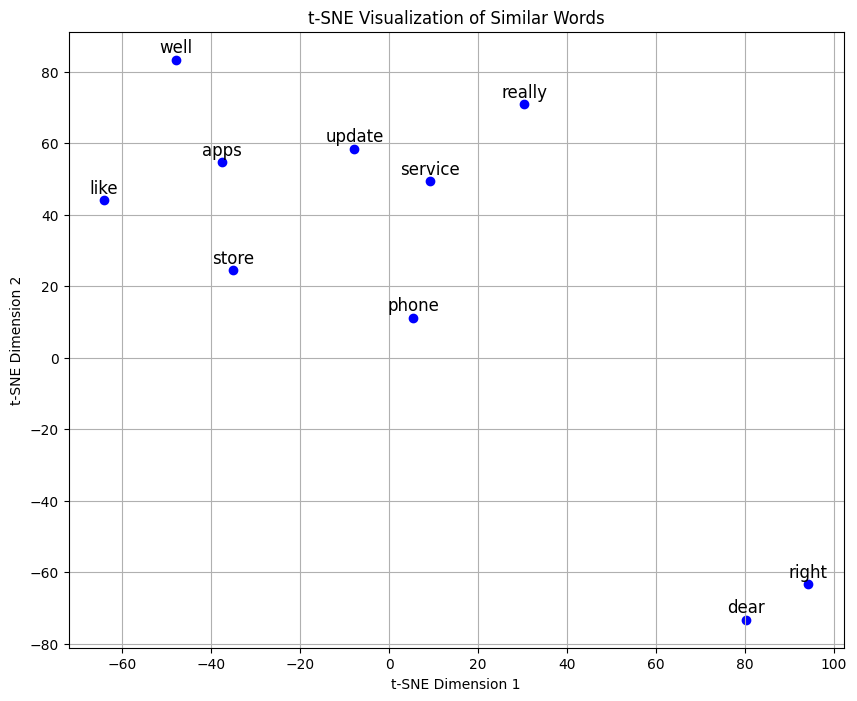

In [160]:
# Visualizing the most similar words using t-sne and sactterplot
# Get vectors and words
words = [word for word, _ in sim_words_doc2vec]
word_vectors = [model_doc2vec.wv[word] for word in words]
word_vectors = np.array(word_vectors)


# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, perplexity=2, init='pca', random_state=0)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], marker='o', c='b')

# Annotate points with word labels
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=12, textcoords='offset points',
                 xytext=(0,5), ha='center', fontproperties='Arial', family='Arial')


plt.title(f"t-SNE Visualization of Similar Words")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

In [164]:
# Odd-One-Out
lst_exmaple = ['battery', 'apple', 'iphone']
model_doc2vec.wv.doesnt_match(lst_exmaple)

'apple'

In [165]:
# Analogy
model_doc2vec.wv.most_similar(positive=['apple', 'iphone'], negative =['battery'])

[('like', 0.18493448197841644),
 ('done', 0.17139500379562378),
 ('great', 0.13796022534370422),
 ('service', 0.13449831306934357),
 ('right', 0.12326616793870926),
 ('upgrade', 0.12168896198272705),
 ('dear', 0.12101217359304428),
 ('better', 0.11694928258657455),
 ('store', 0.09052019566297531),
 ('customer', 0.0740308091044426)]

## `1. Train a Classifier`

In [188]:
# Random Foresr Classifier
clf = RandomForestClassifier()
clf.fit(X_train_doc2vec, y_train)

y_pred_test = clf.predict(X_test_doc2vec)

In [189]:
# Report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.69      0.97      0.81        63
           1       0.71      0.16      0.26        32

    accuracy                           0.69        95
   macro avg       0.70      0.56      0.53        95
weighted avg       0.70      0.69      0.62        95



In [190]:
accuracy_score(y_test, y_pred_test)  # of a classifier

0.6947368421052632

## `2. Using Cosine Similarity Get Top Similar`

In [191]:
for i in random.choices(range(0, len(X_test)), k=5):
    print(f"ID: {i}")
    print("True label:", colored(y_test[i], 'green'))
    distances = cosine_similarity(X_test_doc2vec[i].reshape(1, EMBED_SIZE), X_train_doc2vec).flatten()
    indices = np.argsort(distances)[::-1]
    for _, j in enumerate(indices[:3]):
        print(f"{_} nearest label is {colored(y_train[j], 'green' if y_train[j]==y_test[i] else 'red')}",
             f"similarity: {colored(round(distances[j], 3), 'yellow')}")

ID: 43
True label: 0
0 nearest label is 0 similarity: 0.999
1 nearest label is 1 similarity: 0.282
2 nearest label is 0 similarity: 0.24
ID: 51
True label: 1
0 nearest label is 0 similarity: 0.252
1 nearest label is 0 similarity: 0.236
2 nearest label is 0 similarity: 0.224
ID: 84
True label: 1
0 nearest label is 0 similarity: 0.242
1 nearest label is 1 similarity: 0.242
2 nearest label is 1 similarity: 0.23
ID: 23
True label: 0
0 nearest label is 0 similarity: 0.285
1 nearest label is 0 similarity: 0.269
2 nearest label is 1 similarity: 0.262
ID: 62
True label: 0
0 nearest label is 0 similarity: 0.268
1 nearest label is 0 similarity: 0.256
2 nearest label is 0 similarity: 0.254


In [192]:
# List to append in it the predicted of test labels
y_pred_test = []

# Loop over the entire test dataset
for i in range(len(X_test)):
    # Compute cosine similarity between the test instance and all training instances
    distances = cosine_similarity(X_test_doc2vec[i].reshape(1, EMBED_SIZE), X_train_doc2vec).flatten()
    # Get the indices of the training instances sorted by similarity in descending order
    indices = np.argsort(distances)[::-1]
    # Get the labels of the three nearest neighbors
    nearest_labels = [y_train[j] for j in indices[:3]]
    # Determine the most common label among the three nearest neighbors
    y_pred_each = Counter(nearest_labels).most_common(1)[0][0]
    # Append to list
    y_pred_test.append(y_pred_each)

# Get Accuracy score
acc = accuracy_score(y_test, y_pred_test)
print(f'Acccuray Score using cosine simlarity is: {acc*100:.3f} %') # using cosine similarity as a metric

Acccuray Score using cosine simlarity is: 56.842 %


## `3. Using Euclidean Distance for measuring similarity`

In [193]:
for i in random.choices(range(0, len(X_test)), k=5):
    print(f"ID: {i}")
    print("True label:", colored(y_test[i], 'green'))
    distances = euclidean_distances(X_test_doc2vec[i].reshape(1, EMBED_SIZE), X_train_doc2vec).flatten()
    indices = np.argsort(distances)
    for _, j in enumerate(indices[:3]):
        print(f"{_} nearest label is {colored(y_train[j], 'green' if y_train[j]==y_test[i] else 'red')}",
             f"similarity: {colored(round(distances[j], 3), 'yellow')}")

ID: 77
True label: 0
0 nearest label is 0 similarity: 0.034
1 nearest label is 1 similarity: 0.035
2 nearest label is 1 similarity: 0.035
ID: 69
True label: 1
0 nearest label is 1 similarity: 0.033
1 nearest label is 1 similarity: 0.034
2 nearest label is 0 similarity: 0.034
ID: 18
True label: 0
0 nearest label is 1 similarity: 0.033
1 nearest label is 0 similarity: 0.033
2 nearest label is 0 similarity: 0.035
ID: 9
True label: 1
0 nearest label is 0 similarity: 0.033
1 nearest label is 0 similarity: 0.033
2 nearest label is 1 similarity: 0.034
ID: 14
True label: 0
0 nearest label is 0 similarity: 0.033
1 nearest label is 0 similarity: 0.035
2 nearest label is 0 similarity: 0.035


In [194]:
# List to append in it the predicted of test labels
y_pred_test = []

# Loop over the entire test dataset
for i in range(len(X_test)):

    # Compute euclidean_distances between the test instance and all training instances
    distances = euclidean_distances(X_test_doc2vec[i].reshape(1, EMBED_SIZE), X_train_doc2vec).flatten()
    # Get the indices of the training instances sorted by distance in ascending order
    indices = np.argsort(distances)
    # Get the labels of the three nearest neighbors
    nearest_labels = [y_train[j] for j in indices[:3]]
    # Determine the most common label among the three nearest neighbors
    y_pred_each = Counter(nearest_labels).most_common(1)[0][0]
    # Append to list
    y_pred_test.append(y_pred_each)

# Get Accuracy score
acc = accuracy_score(y_test, y_pred_test)
print(f'Acccuray Score using Euclidean Distance is: {acc*100:.3f} %') # usign euclidean distance

Acccuray Score using Euclidean Distance is: 61.053 %




---



# `Embedding CNN with n_gram`

In [196]:
# Load the GloVe model from spacy
nlp = spacy.load('en_core_web_md')

In [198]:
# Get the longest length text in X
longest_input = max(len(doc.split()) for doc in X_train)
longest_input

15

In [199]:
# truncation to make max tokens in each doc (first 500) with each token embedding of size 300
MAX_TOKENS = 500
EMBED_SIZE = 300

In [200]:
# Embeddings for training data (3D matrix) as I want to incoroprate n-gram (get embeddings for each token)
X_train_embed = np.zeros((len(X_train), MAX_TOKENS, EMBED_SIZE))
for i, doc in enumerate(tqdm(nlp.pipe(X_train), total=len(X_train))):
    for j, token in enumerate(doc):
        if j >= MAX_TOKENS:
            break
        X_train_embed[i, j] = token.vector

  0%|          | 0/380 [00:00<?, ?it/s]

In [201]:
# Embeddings for testing data (3D matrix) as I want to incoroprate n-gram (get embeddings for each token)
X_test_embed = np.zeros((len(X_test), MAX_TOKENS, EMBED_SIZE))
for i, doc in enumerate(tqdm(nlp.pipe(X_test), total=len(X_test))):
    for j, token in enumerate(doc):
        if j >= MAX_TOKENS:
            break
        X_test_embed[i, j] = token.vector

  0%|          | 0/95 [00:00<?, ?it/s]

In [202]:
# Prepare target
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

## `Build a CNN Model`

In [203]:
# Define the functional model with 1D convolutions
inputs = tf.keras.layers.Input(shape=(MAX_TOKENS, EMBED_SIZE))

# Convolution Layers with different kernel (different combination of n-gram)
conv_1 = tf.keras.layers.Conv1D(filters=100, kernel_size=3, activation='relu')(inputs)
conv_2 = tf.keras.layers.Conv1D(filters=100, kernel_size=4, activation='relu')(inputs)
conv_3 = tf.keras.layers.Conv1D(filters=100, kernel_size=5, activation='relu')(inputs)

# Pooling Layer for each cnn (I used Global to take the max value from the whole feature map instead of using kernel)
pool_1 = tf.keras.layers.GlobalMaxPooling1D()(conv_1)
pool_2 = tf.keras.layers.GlobalMaxPooling1D()(conv_2)
pool_3 = tf.keras.layers.GlobalMaxPooling1D()(conv_3)

# Merge them all
merged_tensor = tf.keras.layers.concatenate([pool_1, pool_2, pool_3], axis=1)

# Flatten and add dense layers
flatten = tf.keras.layers.Flatten()(merged_tensor)
clf = tf.keras.layers.Dense(100, activation='relu')(flatten)
clf = tf.keras.layers.Dropout(0.5)(clf)
clf = tf.keras.layers.Dense(len(encoder.classes_), activation='softmax')(clf)

In [204]:
# Compile the model
model = tf.keras.models.Model(inputs, clf)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 500, 300)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 498, 100)       │         90,100 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 497, 100)       │        120,100 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 496, 100)       │        150,100 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 100)            │              0 │ conv1d[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 100)            │              0 │ conv1d_1[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 100)            │              0 │ conv1d_2[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 300)            │              0 │ global_max_pooling1d[… │
│                           │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 300)            │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 100)            │         30,100 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 100)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │            202 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 390,602 (1.49 MB)

 Trainable params: 390,602 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [205]:
# Train the model
history = model.fit(X_train_embed, y_train_encoded,
                    validation_data=(X_test_embed, y_test_encoded),
                    epochs=10,
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 765ms/step - accuracy: 0.5588 - loss: 2.0952 - val_accuracy: 0.6737 - val_loss: 0.6053
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 709ms/step - accuracy: 0.7400 - loss: 0.6193 - val_accuracy: 0.7684 - val_loss: 0.4462
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 593ms/step - accuracy: 0.8377 - loss: 0.3326 - val_accuracy: 0.8526 - val_loss: 0.4267
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 598ms/step - accuracy: 0.9315 - loss: 0.2283 - val_accuracy: 0.8105 - val_loss: 0.4543
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 801ms/step - accuracy: 0.9367 - loss: 0.1639 - val_accuracy: 0.8421 - val_loss: 0.4721
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 587ms/step - accuracy: 0.9241 - loss: 0.1324 - val_accuracy: 0.8632 - val_loss: 0.4584


In [206]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_embed, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.8326 - loss: 0.4388
Test Loss: 0.4267480671405792
Test Accuracy: 0.8526315689086914


In [208]:
# Print classification report
y_pred_enc = model.predict(X_test_embed)
y_pred = encoder.inverse_transform(np.argmax(y_pred_enc, axis=1))
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in encoder.classes_]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        63
           1       0.82      0.72      0.77        32

    accuracy                           0.85        95
   macro avg       0.84      0.82      0.83        95
weighted avg       0.85      0.85      0.85        95



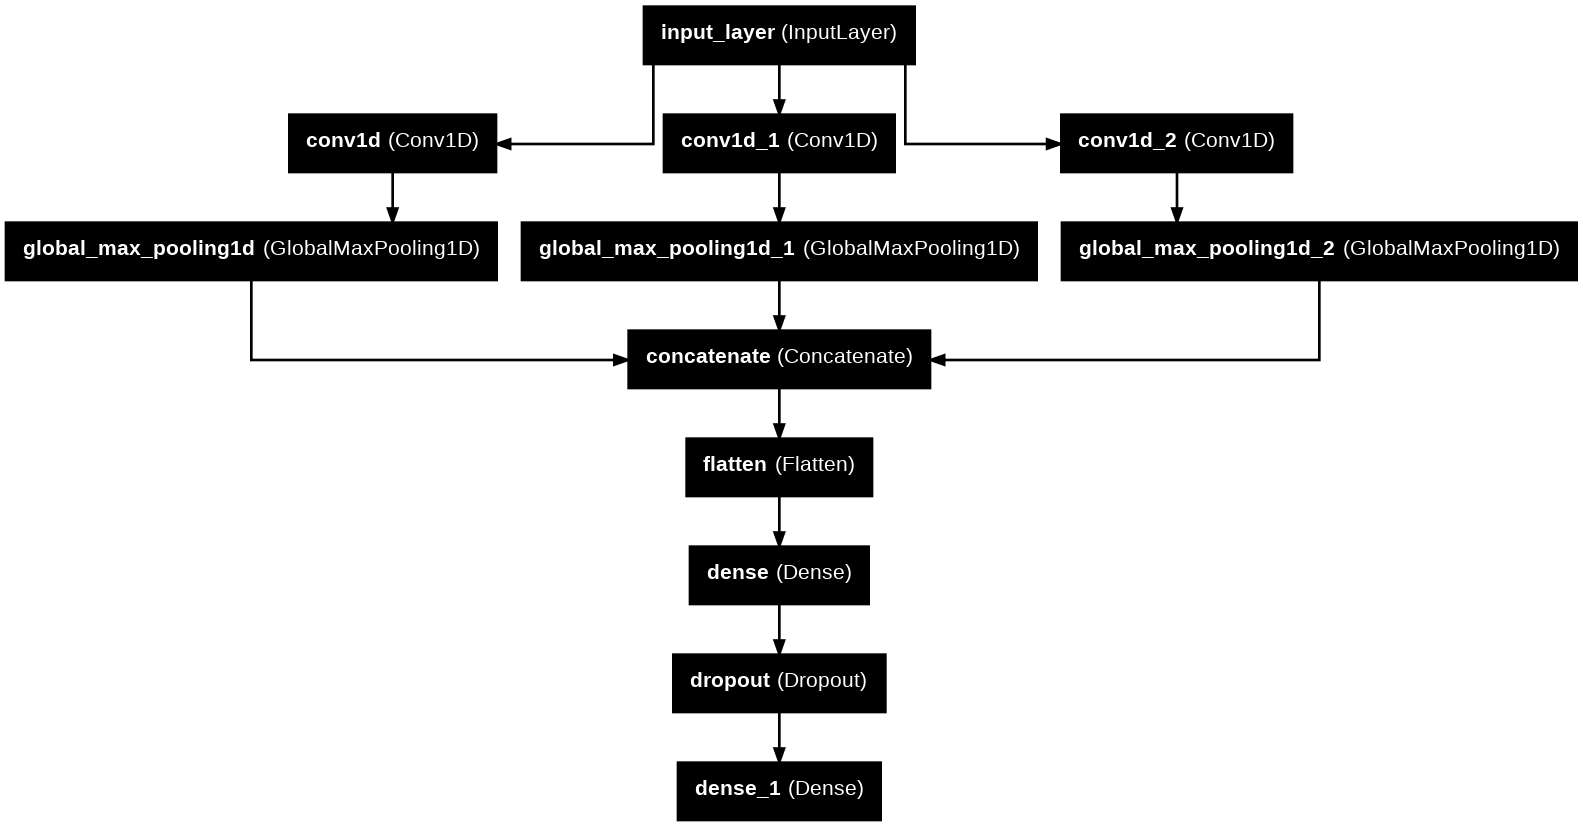

In [209]:
# Can show the graph of the model
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

## `2. Using cosine similarity`

In [210]:
# Merge to get one vector for each document (n_docs, embed_size)
X_train_merged = np.mean(X_train_embed, axis=1)
X_test_merged = np.mean(X_test_embed, axis=1)

In [211]:
for i in random.choices(range(0, len(X_test_merged)), k=5):
    print(f"ID: {i}")
    print("True label:", colored(y_test[i], 'green'))
    distances = cosine_similarity(X_test_merged[i].reshape(1, EMBED_SIZE), X_train_merged).flatten()
    indices = np.argsort(distances)[::-1]
    for _, j in enumerate(indices[:3]):
        print(f"{_} nearest label is {colored(y_train[j], 'green' if y_train[j]==y_test[i] else 'red')}",
             f"similarity: {colored(round(distances[j], 3), 'yellow')}")

ID: 75
True label: 0
0 nearest label is 0 similarity: 0.705
1 nearest label is 0 similarity: 0.652
2 nearest label is 0 similarity: 0.648
ID: 51
True label: 1
0 nearest label is 0 similarity: 0.792
1 nearest label is 0 similarity: 0.748
2 nearest label is 0 similarity: 0.747
ID: 19
True label: 1
0 nearest label is 1 similarity: 0.778
1 nearest label is 1 similarity: 0.744
2 nearest label is 1 similarity: 0.725
ID: 23
True label: 0
0 nearest label is 0 similarity: 0.737
1 nearest label is 0 similarity: 0.731
2 nearest label is 0 similarity: 0.73
ID: 11
True label: 0
0 nearest label is 0 similarity: 0.77
1 nearest label is 0 similarity: 0.766
2 nearest label is 0 similarity: 0.757


In [212]:
# List to append in it the predicted of test labels
y_pred_test = []

# Loop over the entire test dataset
for i in range(len(X_test)):
    # Compute cosine similarity between the test instance and all training instances
    distances = cosine_similarity(X_test_merged[i].reshape(1, EMBED_SIZE), X_train_merged).flatten()
    # Get the indices of the training instances sorted by similarity in descending order
    indices = np.argsort(distances)[::-1]
    # Get the labels of the three nearest neighbors
    nearest_labels = [y_train[j] for j in indices[:3]]
    # Determine the most common label among the three nearest neighbors
    y_pred_each = Counter(nearest_labels).most_common(1)[0][0]
    # Append to list
    y_pred_test.append(y_pred_each)

# Get Accuracy score
acc = accuracy_score(y_test, y_pred_test)
print(f'Acccuray Score using cosine simlarity is: {acc*100:.3f} %') # using cosine similarity as a metric

Acccuray Score using cosine simlarity is: 75.789 %


## `3. Using Euclidean Distance for measuring similarity`

In [213]:
for i in random.choices(range(0, len(X_test)), k=5):
    print(f"ID: {i}")
    print("True label:", colored(y_test[i], 'green'))
    distances = euclidean_distances(X_test_merged[i].reshape(1, EMBED_SIZE), X_train_merged).flatten()
    indices = np.argsort(distances)
    for _, j in enumerate(indices[:3]):
        print(f"{_} nearest label is {colored(y_train[j], 'green' if y_train[j]==y_test[i] else 'red')}",
             f"similarity: {colored(round(distances[j], 3), 'yellow')}")

ID: 77
True label: 0
0 nearest label is 1 similarity: 0.29
1 nearest label is 1 similarity: 0.29
2 nearest label is 0 similarity: 0.291
ID: 78
True label: 0
0 nearest label is 1 similarity: 0.315
1 nearest label is 0 similarity: 0.318
2 nearest label is 0 similarity: 0.318
ID: 3
True label: 0
0 nearest label is 0 similarity: 0.234
1 nearest label is 1 similarity: 0.24
2 nearest label is 0 similarity: 0.258
ID: 7
True label: 1
0 nearest label is 1 similarity: 0.0
1 nearest label is 0 similarity: 0.154
2 nearest label is 0 similarity: 0.154
ID: 66
True label: 0
0 nearest label is 1 similarity: 0.144
1 nearest label is 1 similarity: 0.159
2 nearest label is 0 similarity: 0.16


In [214]:
# List to append in it the predicted of test labels
y_pred_test = []

# Loop over the entire test dataset
for i in range(len(X_test)):

    # Compute euclidean_distances between the test instance and all training instances
    distances = euclidean_distances(X_test_merged[i].reshape(1, EMBED_SIZE), X_train_merged).flatten()
    # Get the indices of the training instances sorted by distance in ascending order
    indices = np.argsort(distances)
    # Get the labels of the three nearest neighbors
    nearest_labels = [y_train[j] for j in indices[:3]]
    # Determine the most common label among the three nearest neighbors
    y_pred_each = Counter(nearest_labels).most_common(1)[0][0]
    # Append to list
    y_pred_test.append(y_pred_each)

# Get Accuracy score
acc = accuracy_score(y_test, y_pred_test)
print(f'Acccuray Score using Euclidean Distance is: {acc*100:.3f} %') # usign euclidean distance

Acccuray Score using Euclidean Distance is: 68.421 %
